In [1]:
# Import libraries
import pickle
import requests
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)

load_dotenv()
key = os.getenv('API_KEY')
api_url = "http://api.positionstack.com/v1/forward"

longLats = pickle.load(open('./longLat.pkl', 'rb'))
len(longLats)

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
df = df[(df.town=="YISHUN") & (df.date > date_max-12)]

from pathlib import Path
file = Path('./data/YISHUN_June22_May23.csv')
df.to_csv(file,index=False)
df


1055

In [4]:
blk_street = df.block + ' ' + df.street_name

responses = []
for i,add in enumerate(blk_street.unique()):
  response = requests.get(f"{api_url}?access_key={key}&query={add}+singapore")
  responses.append(response.json())
  first_response = response.json()['data'][0]
  j = 0
  if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
    longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
    if (j==10):
      print(f"{first_response['label']}, confidence {first_response['confidence']}, {i} of {len(blk_street.unique())}")
      j = 0
  else:
    print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")

pickle.dump(longLats, open('./longLat.pkl', 'wb'))
len(longLats)


459 Yishun Avenue 11, Singapore, confidence 1, 0 of 542
671B Yishun Avenue 4, Singapore, confidence 1, 1 of 542
431B Yishun Avenue 1, Singapore, confidence 1, 2 of 542
431B Yishun Avenue 1, Singapore, confidence 1, 3 of 542
673 Yishun Avenue 4, Singapore, confidence 1, 4 of 542
734 Yishun Avenue 5, Singapore, confidence 1, 5 of 542
704 Yishun Avenue 5, Singapore, confidence 1, 6 of 542
740 Yishun Avenue 5, Singapore, confidence 1, 7 of 542
320 Yishun Central, Singapore, confidence 1, 8 of 542
803 Yishun Ring Road, Singapore, confidence 1, 9 of 542
114 Yishun Ring Road, Singapore, confidence 1, 10 of 542
365 Yishun Ring Road, Singapore, confidence 1, 11 of 542
409 Yishun Ring Road, Singapore, confidence 1, 12 of 542
849 Yishun Ring Road, Singapore, confidence 1, 13 of 542
813B Yishun Ring Road, Singapore, confidence 1, 14 of 542
118 Yishun Ring Road, Singapore, confidence 1, 15 of 542
145 Yishun Street 11, Singapore, confidence 1, 16 of 542
128 Yishun Street 11, Singapore, confidence 1,

1572

In [5]:
blk_street.unique()

array(['459 YISHUN AVE 11', '671B YISHUN AVE 4', '431C YISHUN AVE 1', '431B YISHUN AVE 1', '673A YISHUN AVE 4',
       '734 YISHUN AVE 5', '704 YISHUN AVE 5', '740 YISHUN AVE 5', '320 YISHUN CTRL', '803 YISHUN RING RD', '114 YISHUN RING RD',
       '365 YISHUN RING RD', '409 YISHUN RING RD', '849 YISHUN RING RD', '813B YISHUN RING RD', '118 YISHUN RING RD',
       '145 YISHUN ST 11', '128 YISHUN ST 11', '124 YISHUN ST 11', '225 YISHUN ST 21', '222 YISHUN ST 21', '216 YISHUN ST 21',
       '220 YISHUN ST 21', '205 YISHUN ST 21', '263 YISHUN ST 22', '269 YISHUN ST 22', '266 YISHUN ST 22', '334D YISHUN ST 31',
       '335A YISHUN ST 31', '513C YISHUN ST 51', '714 YISHUN ST 71', '717 YISHUN ST 71', '761 YISHUN ST 72', '746 YISHUN ST 72',
       '736 YISHUN ST 72', '852 YISHUN ST 81', '458 YISHUN AVE 11', '427 YISHUN AVE 11', '443 YISHUN AVE 11',
       '343 YISHUN AVE 11', '445 YISHUN AVE 11', '428A YISHUN AVE 11', '784 YISHUN AVE 2', '779 YISHUN AVE 2',
       '509C YISHUN AVE 4', '507A Y

In [9]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,430.000000,430.000000,4.300000e+02,430.000000,430.000000,430.000000,430.000000
mean,107.625581,1989.353488,7.509216e+05,8.446512,70.106977,103.845989,1.353073
std,24.721041,6.572577,2.202638e+05,6.091048,3.559379,0.006821,0.005786
min,64.000000,1973.000000,2.950000e+05,2.000000,65.000000,103.829749,1.343878
25%,89.000000,1986.000000,6.080000e+05,5.000000,67.000000,103.842542,1.347570
50%,107.000000,1988.000000,7.365000e+05,8.000000,70.000000,103.847114,1.354749
75%,121.000000,1992.000000,8.922500e+05,11.000000,73.000000,103.851517,1.357968
max,163.000000,2011.000000,1.390000e+06,38.000000,76.000000,103.856777,1.363419


In [10]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
dls.show_batch()

,floor,floor_area_sqm,lease_commence_date,date,lat,long,resale_price
0,11.0,137.000000,1992.0,71.0,1.356682,103.849358,911880.0
1,11.0,121.000000,1986.0,76.0,1.345513,103.848312,880000.0
2,11.0,121.000000,1987.0,65.0,1.346170,103.856010,815000.0
3,5.0,67.000001,1985.0,70.0,1.350116,103.838730,420000.0
4,8.0,120.000000,1986.0,66.0,1.363347,103.834839,825000.0
5,2.0,150.000000,1992.0,76.0,1.356636,103.848610,970000.0
6,8.0,122.000001,1988.0,65.0,1.344904,103.853142,810000.0
7,2.0,104.000000,1985.0,69.0,1.346891,103.849098,643888.0
8,2.0,84.000000,1987.0,65.0,1.348837,103.852898,518000.0
9,17.0,162.000000,1990.0,68.0,1.359045,103.829895,1280000.0


SuggestedLRs(valley=0.0014454397605732083, slide=6.309573450380412e-07)

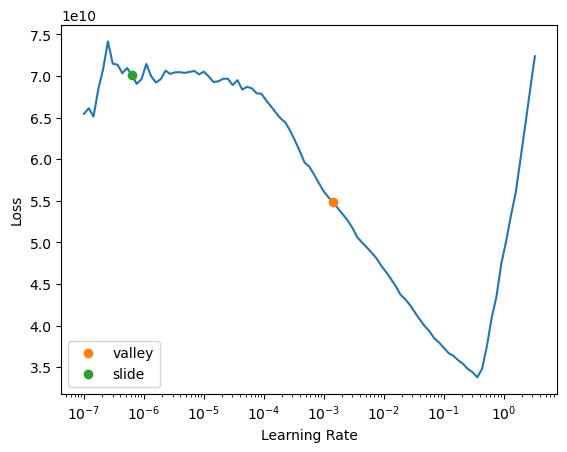

In [11]:
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [30]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-3)
learn.validate()


Better model found at epoch 0 with valid_loss value: 62000.5390625.


(#2) [3930523904.0,62000.5390625]

In [18]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 58564.69921875.


(#2) [3466628352.0,58564.69921875]

In [31]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 7*20
n2 = 6*20
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    _, yPred, _ = learn.predict(row)
    prices[i][j] = yPred.item()
    print(f"{i} of {n1}")

In [33]:
mrts = ["Bishan MRT"]

responses = []
for mrt in mrts:
  response = requests.get(f"{api_url}?access_key={key}&query={mrt}+station+singapore")
  responses.append(response.json())
  first_response = response.json()['data'][0]
  if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
    longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
    print(f"{first_response['label']}, confidence {first_response['confidence']}")
  else:
    print(f"check {mrt}. confidence of {first_response['confidence']}")

pickle.dump(longLats, open('./longLat.pkl', 'wb'))
len(longLats)


MRT Bishan Depot, Singapore, confidence 1


1055

In [35]:
longLats["Bishan MRT"] = (103.84825, 1.35094)
pickle.dump(longLats, open('./longLat.pkl', 'wb'))


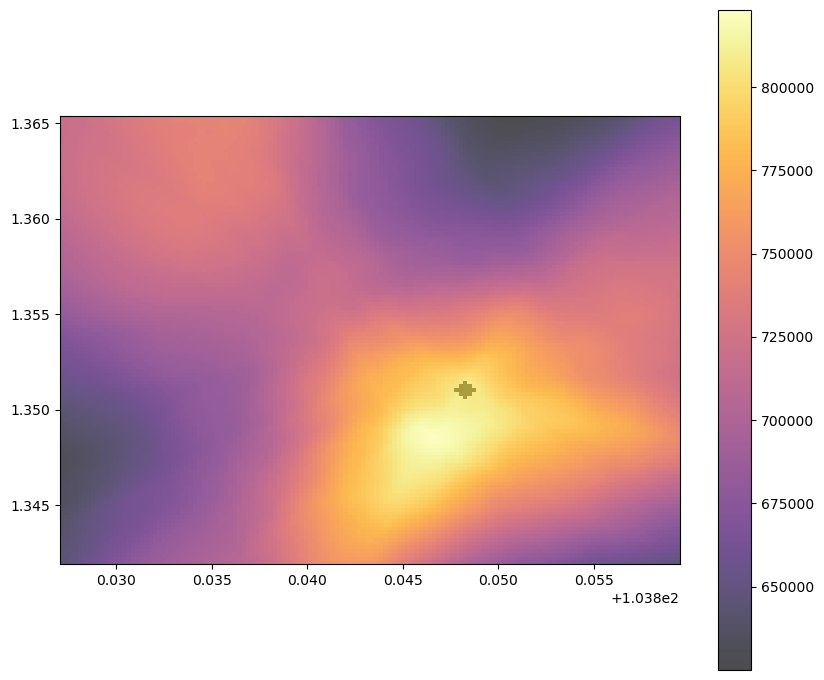

In [36]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
mrt_map = np.zeros((n2,n1))
#mrts = ["Yio Chu Kang MRT", "Ang Mo Kio MRT"]
#for mrt in mrts:
#  (i,j) = min_coords(*longLats[mrt])
#  #for m in range(3):
#  #  for n in range(3):
#  mrt_map[j+m-1][i+n-1] = 1

"""
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j+1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j-1][i-2]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i+2]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
(i,j) = min_coords(*longLats[mrts[4]])
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i-2]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+2]=1
mrt_map[j+1][i+1]=1
mrt_map[j+1][i]=1
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j-2][i+1]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i+1]=1
mrt_map[j+2][i+1]=1
(i,j) = min_coords(*longLats[mrts[2]])
mrt_map[j-2][i-1]=1
mrt_map[j-1][i-1]=1
mrt_map[j-1][i]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+2][i-1]=1
"""
(i,j) = min_coords(*longLats[mrts[0]])
mrt_map[j+1][i]=1
mrt_map[j+1][i-1]=1
mrt_map[j+1][i+1]=1
mrt_map[j-1][i]=1
mrt_map[j-1][i+1]=1
mrt_map[j-1][i-1]=1
mrt_map[j][i]=1
mrt_map[j][i-1]=1
mrt_map[j][i+1]=1
mrt_map[j][i-2]=1
mrt_map[j][i+2]=1
mrt_map[j+2][i]=1
mrt_map[j-2][i]=1

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/7*6)

plt.show()

In [50]:
longLeft,longRight

(103.8288214, 103.8619606)

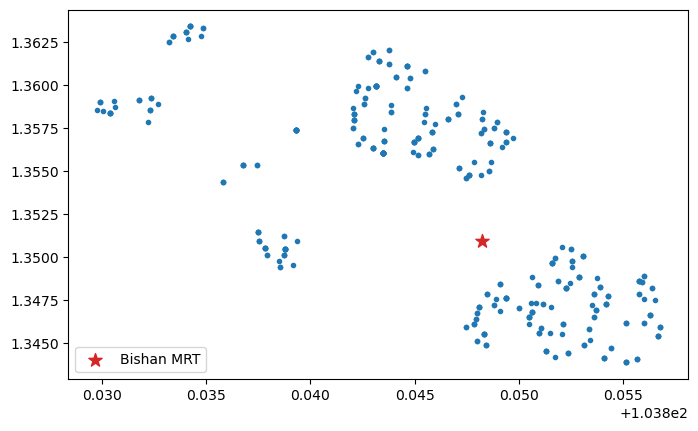

In [37]:
markers = ["*"]

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='lower left')
fig.set_figwidth(8)

plt.show()


for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
